## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Input, LSTM
from tensorflow.keras.models import Sequential

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

В качестве текста для обучения выберем Шекспира

In [2]:
# Поскольку файл уже скачан прочитаем его и сохраним в переменную
with open('data/sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

# Посмотрим как выглядит текст сейчас
text[-5:]

["  Which from Love's fire took heat perpetual,\n",
 '  Growing a bath and healthful remedy,\n',
 "  For men diseas'd; but I, my mistress' thrall,\n",
 '    Came there for cure and this by that I prove,\n',
 "    Love's fire heats water, water cools not love.\n"]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

# Посмотрим как выглядит текст после преобразований
text[-60:]

OK!


"i prove,\n    love's fire heats water, water cools not love.\n"

Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))
# Проверим корректность
len(tokens)

38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# Создадим словарь dict <index>:<char>
idx_to_token = {}
# Пройдемся по каждому элементу списка токенов и присвоим индекс
for i in range(len(tokens)):
    idx_to_token[i] = tokens[i]

# Создадим также массив для хранения токенов, для удобства обращения
idx_to_token_np = np.array(tokens)

# Аналогично словарю выше, но меняются местами индексы и символы dict <char>:<index>
token_to_idx = {}
for i in range(len(tokens)):
    token_to_idx[tokens[i]] = i
    
# Преобразуем весь текст в индексы
text_as_int = np.array([token_to_idx[c] for c in text])
text_as_int[-10:]

array([25, 26, 31,  1, 23, 26, 33, 16,  8,  0])

In [6]:
seq_length = 100

# преобразование кодировок text_as_int в тензоры
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

# посмотрим как это выглядит
[idx_to_token[int(i)] for i in char_dataset.take(10)]

[' ', ' ', 'f', 'r', 'o', 'm', ' ', 'f', 'a', 'i']

In [7]:
# Разобьем наш документ на обучающие последовательности
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
[repr(''.join(idx_to_token_np[item.numpy()])) for item in sequences.take(5)]

['"  from fairest creatures we desire increase,\\n  that thereby beauty\'s rose might never die,\\n  but as t"',
 "'he riper should by time decease,\\n  his tender heir might bear his memory:\\n  but thou, contracted to t'",
 '"hine own bright eyes,\\n  feed\'st thy light\'s flame with self-substantial fuel,\\n  making a famine where"',
 '" abundance lies,\\n  thy self thy foe, to thy sweet self too cruel:\\n  thou that art now the world\'s fre"',
 "'sh ornament,\\n  and only herald to the gaudy spring,\\n  within thine own bud buriest thy content,\\n  and'"]

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
# Создадим входную и таргетовую последовательности
# таргетовая это входная смещенная на 1 вправо
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
# Так выглядит получившаяся последовательность в цифровом представлении
list(dataset)[0]

(<tf.Tensor: shape=(100,), dtype=int32, numpy=
 array([ 1,  1, 17, 29, 26, 24,  1, 17, 12, 20, 29, 16, 30, 31,  1, 14, 29,
        16, 12, 31, 32, 29, 16, 30,  1, 34, 16,  1, 15, 16, 30, 20, 29, 16,
         1, 20, 25, 14, 29, 16, 12, 30, 16,  6,  0,  1,  1, 31, 19, 12, 31,
         1, 31, 19, 16, 29, 16, 13, 36,  1, 13, 16, 12, 32, 31, 36,  3, 30,
         1, 29, 26, 30, 16,  1, 24, 20, 18, 19, 31,  1, 25, 16, 33, 16, 29,
         1, 15, 20, 16,  6,  0,  1,  1, 13, 32, 31,  1, 12, 30,  1])>,
 <tf.Tensor: shape=(100,), dtype=int32, numpy=
 array([ 1, 17, 29, 26, 24,  1, 17, 12, 20, 29, 16, 30, 31,  1, 14, 29, 16,
        12, 31, 32, 29, 16, 30,  1, 34, 16,  1, 15, 16, 30, 20, 29, 16,  1,
        20, 25, 14, 29, 16, 12, 30, 16,  6,  0,  1,  1, 31, 19, 12, 31,  1,
        31, 19, 16, 29, 16, 13, 36,  1, 13, 16, 12, 32, 31, 36,  3, 30,  1,
        29, 26, 30, 16,  1, 24, 20, 18, 19, 31,  1, 25, 16, 33, 16, 29,  1,
        15, 20, 16,  6,  0,  1,  1, 13, 32, 31,  1, 12, 30,  1, 31])>)

In [9]:
# Так выглядит получившаяся последовательность в буквенном представлении
for input_example, target_example in dataset.take(1):
    print ('Input data: ', repr(''.join(idx_to_token_np[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx_to_token_np[target_example.numpy()])))

Input data:  "  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as "
Target data: " from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as t"


In [10]:
# Гиперпараметры для модели
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

vocab_size = len(tokens)
embedding_dim = 256
rnn_units = 1024

In [11]:
clear_session()

In [12]:
# Создаем модель
model_vanilla_rnn = Sequential()
model_vanilla_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model_vanilla_rnn.add(SimpleRNN(
    rnn_units,
    return_sequences=True,
    stateful=True,
    recurrent_initializer='glorot_uniform'))
model_vanilla_rnn.add(Dense(vocab_size))

In [13]:
# Скомпелируем модель
model_vanilla_rnn.compile(optimizer='adam', 
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Обучим модель
history = model_vanilla_rnn.fit(dataset, epochs=50)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 667ms/step - loss: 3.5084
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 685ms/step - loss: 2.8576
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 667ms/step - loss: 2.5250
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 689ms/step - loss: 2.3042
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 694ms/step - loss: 2.1868
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 737ms/step - loss: 2.1143
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 997ms/step - loss: 2.0424
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 954ms/step - loss: 1.9948
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 850ms/step - loss: 1.9501
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 923ms/step - loss: 1.8983
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 1.8520
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 1.8147
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 1.7681
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 949ms/step - loss: 1.7481
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step -

In [14]:
# Сохраним веса модели, они понадобятся для генерации текста
model_vanilla_rnn.save_weights('model/vanilla_rnn.weights.h5')

In [27]:
# Функция для генерации текста 
def generate_text(model_type='vanilla_rnn', start_string='love', temp=1.0, gen_chars=100): 
    # Построим новую модель, используя только 1 вход 
    # заранее разделим на 2 модели vanilla_rnn и lstm
    model_pred = Sequential()
    model_pred.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    
    if model_type == 'vanilla_rnn':
        model_pred.add(SimpleRNN(
            rnn_units,
            return_sequences=True,
            stateful=True,
            recurrent_initializer='glorot_uniform'))
        
    elif model_type == 'lstm':
        model_pred.add(LSTM(
            rnn_units,
            return_sequences=True,
            stateful=True,
            recurrent_initializer='glorot_uniform'))
    
    model_pred.add(Dense(vocab_size))
    model_pred.build(input_shape=(1, None))
    # Загрузим ранее обученные веса
    model_pred.load_weights('model/' + model_type + '.weights.h5') 
    
    input_eval = [token_to_idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)  
    text_generated = []
    
    # Побуквенно генерируем сообщение от нейросети
    for i in range(gen_chars):
        predictions = model_pred(input_eval)      
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temp
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx_to_token_np[predicted_id])  
    return (start_string + ''.join(text_generated))

In [29]:
# Сгенерируем текст и узнаем, что модель думает о любви
generated_text = generate_text('vanilla_rnn', "love is", 1.0, 200)
print(generated_text)

love is in her thook, speaking.

  lxiv

  agawning on wintees treasure those;
  for through dissance censlearth,
  and part his tiones of less diching,
  and acceqiage promber'd stake,
  or embers nothing h


Plot the loss function (axis X: number of epochs, axis Y: loss function).

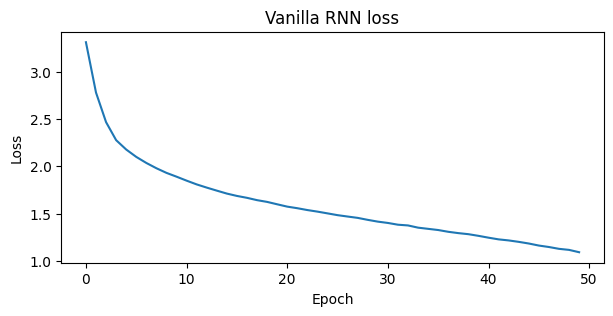

In [17]:
plt.style.use(['default'])
fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1)
# Построим график потерь в зависимости от эпохи
ax.plot(history.history['loss'])
ax.set_title('Vanilla RNN loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.show()

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [18]:
# Создаем новую модель
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model_lstm.add(LSTM(
    rnn_units,
    return_sequences=True,
    stateful=True,
    recurrent_initializer='glorot_uniform'))
model_lstm.add(Dense(vocab_size))

In [19]:
# Скомпелируем модель
model_lstm.compile(optimizer='adam', 
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Обучим модель
history = model_lstm.fit(dataset, epochs=50)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - loss: 3.4219
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - loss: 2.8623
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - loss: 2.5479
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - loss: 2.3170
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - loss: 2.1792
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - loss: 2.0796
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - loss: 1.9940
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - loss: 1.9301
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - loss: 1.8697
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - loss: 1.8087
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 1.7696
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - loss: 1.7163
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - loss: 1.6868
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - loss: 1.6401
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - loss: 1.5965
Epoch 16/50
15/15 ━

In [20]:
# Также сохраним веса
model_lstm.save_weights('model/lstm.weights.h5')

# Посмотрим на сгенерированный текст и узнаем, что эта модель думает о любви
generated_text = generate_text('lstm', "love is", 1.0, 200)
print(generated_text)

love is suck a stronger than wher thau seem the ton,
    and bryough to kings her till dhe can be,
    compit of him thou art not poor both shall ad my advantage should he it sunvy stray
  to be death's cann


Plot the loss function of the number of epochs. Does the final loss become better?

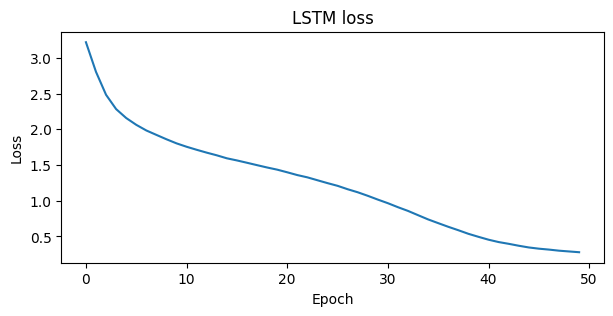

In [21]:
plt.style.use(['default'])
fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1)
# Построим график потерь в зависимости от эпохи
ax.plot(history.history['loss'])
ax.set_title('LSTM loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.show()

По результатам обучения двух моделей и их графикам функций потерь можно сказать, что вторая модель (LSTM) показывает лучшие реультаты при том же количестве эпох, но время на ее обучение уходит больше раза в 3-4. 

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [30]:
print('Text generated by Vanilla RNN')
print('<><><><><><><><><><><><>')

generated_text = generate_text('vanilla_rnn', "love is", 0.1, 200)
print('Generated text with 0.1 temprature:')
print(generated_text)
print('-----------------------')

generated_text = generate_text('vanilla_rnn', "love is", 0.2, 200)
print('Generated text with 0.2 temprature:')
print(generated_text)
print('-----------------------')

generated_text = generate_text('vanilla_rnn', "love is", 1.0, 200)
print('Generated text with 1.0 temprature:')
print(generated_text)
print('-----------------------')

generated_text = generate_text('vanilla_rnn', "love is", 2.0, 200)
print('Generated text with 2.0 temprature:')
print(generated_text)
print('-----------------------')

Text generated by Vanilla RNN
<><><><><><><><><><><><>
Generated text with 0.1 temprature:
love is the world and there;
  and therefore love thee that the thing the world and there;
  and the dear thy self thy self thy self thy self thy self thy self thy self thy self thy sweet self thy self thy s
-----------------------
Generated text with 0.2 temprature:
love is thy dear love the lovely days;
  and therefore love that thou shalt find the world and thee the sun,
  can i think on thy self are dead;
  and therefore love thee and the dead;
  and therefore desire
-----------------------
Generated text with 1.0 temprature:
love is, he thrivers, impomis'd ne's besiew
  the sport,--man find which it outloss,
  those lovelenge shade,
  when that thou art mercome;
  and her mine ear,
  turn bal, upam surse of heartht;
  for then, 
-----------------------
Generated text with 2.0 temprature:
love is hon timl abass,
  owndgs  of imm,
  a dubb'd lit,
    torthofils?
  noffatrfy lefts it rempsb od,

In [31]:
print('Text generated by LSTM')
print('<><><><><><><><><><><><>')

generated_text = generate_text('lstm', "love is", 0.1, 200)
print('Generated text with 0.1 temprature:')
print(generated_text)
print('-----------------------')

generated_text = generate_text('lstm', "love is", 0.2, 200)
print('Generated text with 0.2 temprature:')
print(generated_text)
print('-----------------------')

generated_text = generate_text('lstm', "love is", 1.0, 200)
print('Generated text with 1.0 temprature:')
print(generated_text)
print('-----------------------')

generated_text = generate_text('lstm', "love is", 2.0, 200)
print('Generated text with 2.0 temprature:')
print(generated_text)
print('-----------------------')

Text generated by LSTM
<><><><><><><><><><><><>
Generated text with 0.1 temprature:
love is such a scope to show her pride,
  the argument, all bare, is of more worth
  than when it hath my adding past is not so blessed not you with most bright,
  to leave for nothing all thy sum of good;
 
-----------------------
Generated text with 0.2 temprature:
love is such a scope to show her pride,
  the argument, all bare, is of more worth
  than when it hath thy mind,
  some in their warkso and thou steal thy sweet that smells, are wealth my dear delight.
    t
-----------------------
Generated text with 1.0 temprature:
love is so,
  if it fears wor'd world be, for this hall co hand,
  to the paiteous day by clessed savery eyes,
  weeds aarenld of true till,
  thy pour friend, have in thy love's with thee,
  westy in being 
-----------------------
Generated text with 2.0 temprature:
love is gazt,
    and so soy 'hull so; not forbid,
  tho besowness, and your to e.

  .v

  tuew'st ad love,'ken

Также можно сделать вывод, что вторая модель (LSTM) генерирует более осознанные тексты, чем Vanilla_RNN, чаще получаются существующие слова и иногда можно наблюдать рифму.

Чем больше значение температуры тем тексты становятся более хаотичными, при температуре 2 уже нельзя различить слова, это скорее похоже на последовательность букв. При температурах 0.1 0.2 модели иногда "заклинивают" на одном слове или словосочетании и повторяют их.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [24]:
# Сохраним и загрузим наши получившиеся модели
model_vanilla_rnn.save('model/vanilla_rnn.keras')
loaded_vanilla_rnn = tf.keras.models.load_model('model/vanilla_rnn.keras')

model_lstm.save('model/lstm.keras')
loaded_lstm = tf.keras.models.load_model('model/lstm.keras')

In [25]:
# Проверим корректность загруки модели
loaded_vanilla_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 100, 256)         │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (64, 100, 1024)        │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 100, 38)          │        38,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,081,268 (15.57 MB)

 Trainable params: 1,360,422 (5.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,720,846 (10.38 MB)

In [26]:
# Проверим корректность загруки модели
loaded_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (64, 100, 256)         │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, 100, 1024)        │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 100, 38)          │        38,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,886,964 (60.60 MB)

 Trainable params: 5,295,654 (20.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,591,310 (40.40 MB)

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)